# Time Series Prediction

In [221]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## 1. Data Preprocessing

In [222]:
file_path = "prices.txt"
df = pd.read_csv(file_path)

In [223]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

In [224]:
df = df.dropna(subset=['Date'])

In [225]:
df = df.sort_values(by='Date')

### Visualizing the stock prices graph over the past 5 years

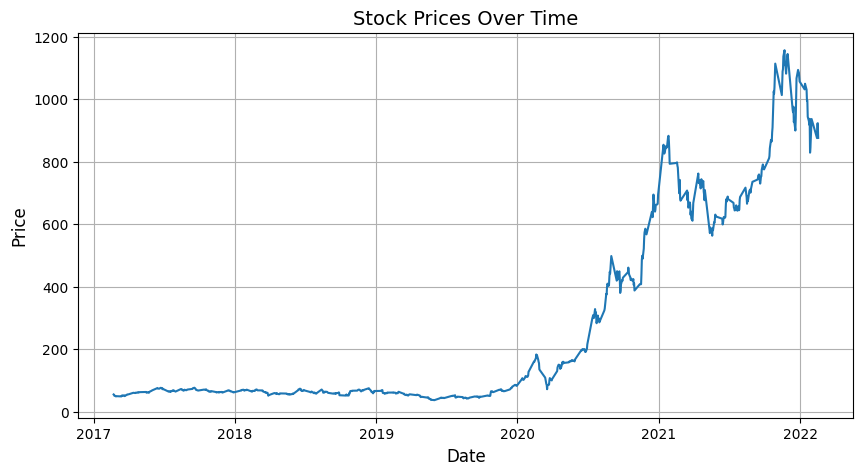

In [226]:
plt.figure(figsize=(10, 5))
plt.plot(df['Date'], df['Price'])
plt.title('Stock Prices Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.grid(True)
plt.show()

### Normalizing the Time-Series Data
The dataset's prices are normalized using `MinMaxScaler`; included in the `sklean` library, to scale values between 0 and 1, ensuring consistent feature scaling and improving model stability during training.

In [227]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df[['Price']])
df['Normalized_Price'] = scaler.transform(df[['Price']])


### Splitting the Data into Training, Validation and Testing Datasets
- **70%** of the data will be used for trianing
- **10%** of the data will be used for validation
- **20%** of the data will be used for testing

In [234]:
train_size = int(len(df) * 0.7)
val_size = int(len(df) * 0.1)

train_data = df[:train_size]
val_data = df[train_size:train_size + val_size]
test_data = df[train_size + val_size:]


### Transforming the Time-Series Data into a List of Sequential Data  

The `create_sequences` function is used to transform the time-series data into a list of sequences, allowing the model to learn from historical patterns. This sequential structure helps the model predict the next stock price at index `i + sequence_length`. The sequence length was set to **5**.

In [236]:
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
        labels.append(data[i+sequence_length])
    return np.array(sequences), np.array(labels)


In [237]:
sequence_length = 5

train_sequences, train_labels = create_sequences(train_data['Normalized_Price'].values, sequence_length)
val_sequences, val_labels = create_sequences(val_data['Normalized_Price'].values, sequence_length)
test_sequences, test_labels = create_sequences(test_data['Normalized_Price'].values, sequence_length)

In [238]:
train_sequences = train_sequences.reshape((train_sequences.shape[0], train_sequences.shape[1], 1))
val_sequences = val_sequences.reshape((val_sequences.shape[0], val_sequences.shape[1], 1))
test_sequences = test_sequences.reshape((test_sequences.shape[0], test_sequences.shape[1], 1))

## 2. Model Architecture  

When selecting a machine learning model for time-series stock price prediction, two architectures were considered:  
- **Long Short-Term Memory (LSTM)** networks, which are well-suited for capturing sequential dependencies in time-series data.
- **Convolutional Neural Networks (CNNs)**, which can extract short-term patterns before feeding them into an LSTM for sequential learning.

## 3. Models Training and Testing

To evaluate the best-performing approach, the following models where trained and tested:

#### **a. Base Double LSTM Model**  
- A simple stacked **LSTM network** with **two LSTM layers** (64 and 32 units).
- Uses a **dropout layer (0.3)** to prevent overfitting.
- Trained for **upto 50 epochs** implementing early stopping.

In [240]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model_1 = Sequential([
    LSTM(64, activation='relu', return_sequences=True),
    Dropout(0.3),
    LSTM(32, activation='relu'),
    Dense(1)
])

model_1.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_1 = model_1.fit(
    train_sequences, train_labels, 
    validation_data=(val_sequences, val_labels),
     epochs=50, 
     batch_size=32, 
     callbacks=[early_stopping],
     verbose=1)

Epoch 1/50
17/17 [==============================] - 3s 28ms/step - loss: 0.0024 - val_loss: 0.1624
Epoch 2/50
17/17 [==============================] - 0s 10ms/step - loss: 0.0017 - val_loss: 0.1412
Epoch 3/50
17/17 [==============================] - 0s 9ms/step - loss: 0.0011 - val_loss: 0.0833
Epoch 4/50
17/17 [==============================] - 0s 8ms/step - loss: 4.1304e-04 - val_loss: 0.0119
Epoch 5/50
17/17 [==============================] - 0s 10ms/step - loss: 2.0678e-04 - val_loss: 0.0090
Epoch 6/50
17/17 [==============================] - 0s 9ms/step - loss: 1.7570e-04 - val_loss: 0.0141
Epoch 7/50
17/17 [==============================] - 0s 8ms/step - loss: 1.7958e-04 - val_loss: 0.0135
Epoch 8/50
17/17 [==============================] - 0s 8ms/step - loss: 1.5752e-04 - val_loss: 0.0084
Epoch 9/50
17/17 [==============================] - 0s 8ms/step - loss: 1.5011e-04 - val_loss: 0.0080
Epoch 10/50
17/17 [==============================] - 0s 9ms/step - loss: 1.6699e-04 - val_l

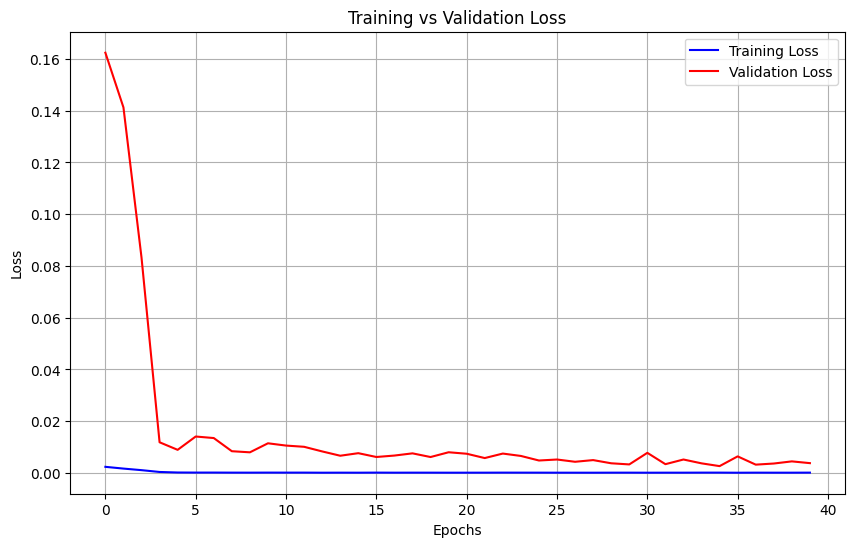

In [241]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history_1.history['loss'], label='Training Loss', color='blue')
plt.plot(history_1.history['val_loss'], label='Validation Loss', color='red')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


**Analysis of Training vs Validation Loss Graph**
- Validation Loss Starts at **0.16** but Rapidly Decreases to **0.01** (Epochs 0-5)
    - This is expected because the model initially struggles with unseen validation data, which has higher price values than the training set (Can be seen in the output of the next cell).
    - The sharp drop indicates the model is quickly learning patterns, even for the higher validation values.
- Validation Loss Remains Higher than Training Loss (Epochs 5-40)
    - This is natural since the validation set contains higher stock prices, which the model didn’t see during training.
    - The gap between training and validation loss suggests the model is generalizing well, though it may still struggle slightly with high-value predictions.
- Validation Loss is Stable, No Overfitting (Post Epoch 10).

In [243]:
print("Train Min/Max:", train_data['Normalized_Price'].min(), train_data['Normalized_Price'].max())
print("Val Min/Max:", val_data['Normalized_Price'].min(), val_data['Normalized_Price'].max())
print("Test Min/Max:", test_data['Normalized_Price'].min(), test_data['Normalized_Price'].max())

Train Min/Max: 0.0 0.2947712006277937
Val Min/Max: 0.30243123988879406 0.7555182361494336
Test Min/Max: 0.4700930168654377 0.9999999999999999


In [244]:
test_loss = model_1.evaluate(test_sequences, test_labels, verbose=1)
print(f"Test Loss: {test_loss}")

5/5 [==============================] - 0s 3ms/step - loss: 0.0031
Test Loss: 0.0031176116317510605


**Train loss is low**
- This suggests that the model predicting stock prices with high accuracy
- Training loss is similar to validation loss, indicating no overfitting
- The model performs similarly on unseen data, meaning it learned patterns effectively without memorizing training data.

In [251]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

predicted_prices = model_1.predict(test_sequences)

predicted_prices = scaler.inverse_transform(predicted_prices)
actual_prices = scaler.inverse_transform(test_labels.reshape(-1, 1))

rmse = mean_squared_error(actual_prices, predicted_prices, squared=False)
mae = mean_absolute_error(actual_prices, predicted_prices)

price_range = actual_prices.max() - actual_prices.min()
price_mean = actual_prices.mean()

nrmse_range = rmse / price_range
nrmse_mean = rmse / price_mean
nmae_range = mae / price_range
nmae_mean = mae / price_mean

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Normalized RMSE (Range): {nrmse_range}")
print(f"Normalized RMSE (Mean): {nrmse_mean}")
print(f"Normalized MAE (Range): {nmae_range}")
print(f"Normalized MAE (Mean): {nmae_mean}")


5/5 [==============================] - 0s 3ms/step
Root Mean Squared Error (RMSE): 62.52680148871866
Mean Absolute Error (MAE): 48.746773789036105
Normalized RMSE (Range): 0.10536863944603553
Normalized RMSE (Mean): 0.07898300722643767
Normalized MAE (Range): 0.08214687316863838
Normalized MAE (Mean): 0.061576263214737186


**Analysis of Actual vs Predicted Prices (Using Normalized Metrics)**
- Normalised Root Mean Square Error (RMSE) (Range) is **10.54%**. This suggests a moderate error relative to the overall price fluctuations. 
- Normalised RMSE (Mean) is **7.89%**. This is lower than 10% which suggests reasonable preditive accuracy.
- Normalised Mean Absolute Error (MAE) (Range) is **8.21%**. This suggests that, on average, the model's predictions are off by 8.21% of the stock’s price range, which is acceptable but could be improved.
- Normalised MAE (Mean) is **6.16%**.  The model’s predictions typically deviate by 6.16% of the mean stock price, which is a relatively low percentage error.

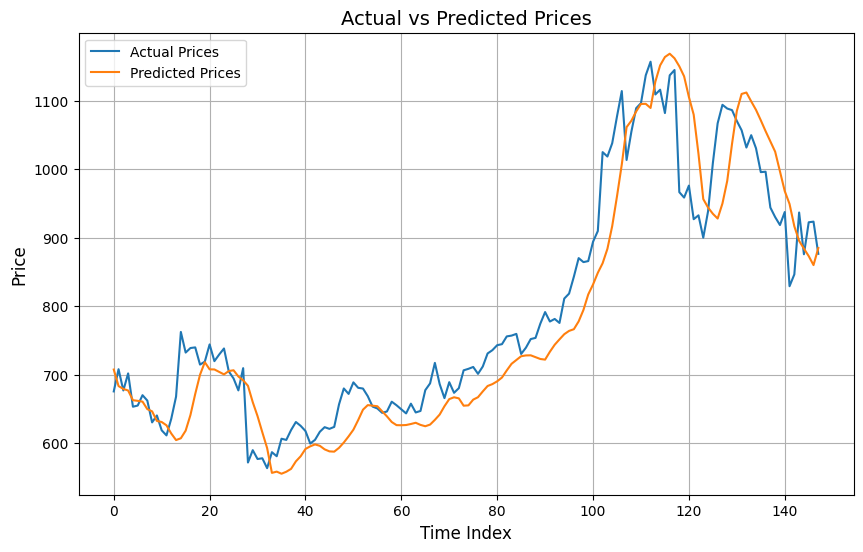

In [248]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(actual_prices)), actual_prices, label="Actual Prices")
plt.plot(range(len(predicted_prices)), predicted_prices, label="Predicted Prices")
plt.title('Actual vs Predicted Prices', fontsize=14)
plt.xlabel('Time Index', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()
plt.grid()
plt.show()

### Analysis of Actual vs Predicted Prices
- The model successfully follows the overall stock price trend, indicating it has learned long-term movements.
- The predicted curve is less volatile than the actual prices, meaning the model struggles with sharp fluctuations and sudden price drops.
- Lag in Peaks and Troughs: The predictions react slower to price changes, especially in rapid increases and declines.

#### **b. CNN-LSTM Hybrid Model**  
- A **Conv1D layer** extracts short-term patterns.
- A **MaxPooling1D layer** reduces dimensionality.
- The output is passed to a **single LSTM layer (64 units)** for sequential learning.
- Trained for **upto 50 epochs** implementng early stopping.

In [268]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

model_2 = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(sequence_length, 1)),
    MaxPooling1D(pool_size=2),
    LSTM(64, activation='relu'),
    Dense(1)
])

model_2.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_2 = model_2.fit(
    train_sequences, train_labels, 
    validation_data=(val_sequences, val_labels),
    epochs=50, 
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1)


Epoch 1/50
17/17 [==============================] - 2s 16ms/step - loss: 0.0022 - val_loss: 0.1203
Epoch 2/50
17/17 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0766
Epoch 3/50
17/17 [==============================] - 0s 4ms/step - loss: 5.7424e-04 - val_loss: 0.0161
Epoch 4/50
17/17 [==============================] - 0s 4ms/step - loss: 1.4071e-04 - val_loss: 0.0020
Epoch 5/50
17/17 [==============================] - 0s 4ms/step - loss: 1.1635e-04 - val_loss: 0.0025
Epoch 6/50
17/17 [==============================] - 0s 4ms/step - loss: 1.0896e-04 - val_loss: 0.0019
Epoch 7/50
17/17 [==============================] - 0s 4ms/step - loss: 1.0906e-04 - val_loss: 0.0019
Epoch 8/50
17/17 [==============================] - 0s 4ms/step - loss: 1.1358e-04 - val_loss: 0.0019
Epoch 9/50
17/17 [==============================] - 0s 4ms/step - loss: 1.0771e-04 - val_loss: 0.0023
Epoch 10/50
17/17 [==============================] - 0s 4ms/step - loss: 1.1584e-04 - val

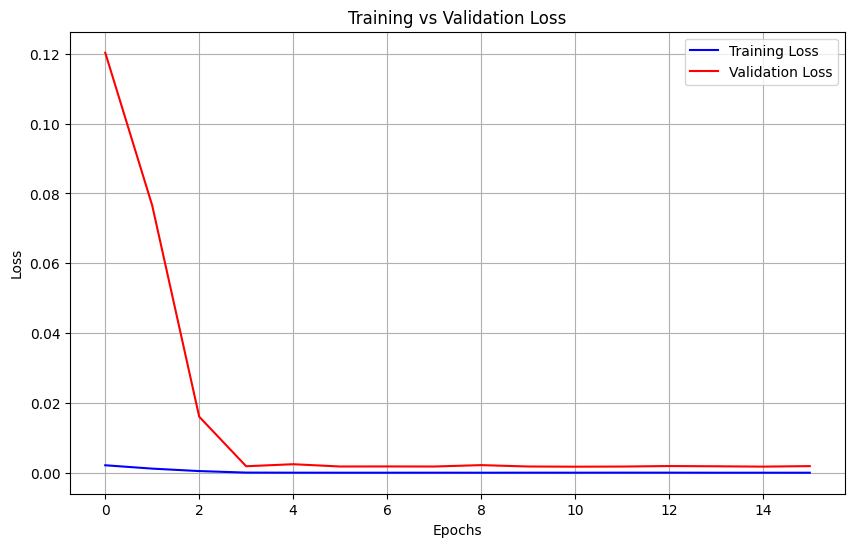

In [269]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history_2.history['loss'], label='Training Loss', color='blue')
plt.plot(history_2.history['val_loss'], label='Validation Loss', color='red')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


**Analysis of Training vs Validation Loss Graph**
- Validation Loss Starts at **0.12** but Rapidly Decreases to Near **0.01** (Epochs 0-3)
    - The model initially struggles with unseen validation data, leading to a high loss.
    - The sharp drop suggests that the model quickly learns meaningful patterns, even for higher validation prices.
- Validation Loss is Stable, No Overfitting (Post Epoch 3)
    - Both training and validation losses plateau at a low level, showing that the model is not overfitting.


In [266]:
test_loss = model_2.evaluate(test_sequences, test_labels, verbose=0)
print(f"Test Loss: {test_loss}")

Test Loss: 0.04678323119878769


**Train loss is low**
- This suggests that the model predicting stock prices with high accuracy
- Training loss is similar to validation loss, indicating no overfitting
- The model performs similarly on unseen data, meaning it learned patterns effectively without memorizing training data.

In [273]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

predicted_prices = model_2.predict(test_sequences)

predicted_prices = scaler.inverse_transform(predicted_prices)
actual_prices = scaler.inverse_transform(test_labels.reshape(-1, 1))

rmse = mean_squared_error(actual_prices, predicted_prices, squared=False)
mae = mean_absolute_error(actual_prices, predicted_prices)

price_range = actual_prices.max() - actual_prices.min()
price_mean = actual_prices.mean()

nrmse_range = rmse / price_range
nrmse_mean = rmse / price_mean
nmae_range = mae / price_range
nmae_mean = mae / price_mean

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Normalized RMSE (Range): {nrmse_range}")
print(f"Normalized RMSE (Mean): {nrmse_mean}")
print(f"Normalized MAE (Range): {nmae_range}")
print(f"Normalized MAE (Mean): {nmae_mean}")


5/5 [==============================] - 0s 2ms/step
Root Mean Squared Error (RMSE): 68.81271964750327
Mean Absolute Error (MAE): 47.88893211235747
Normalized RMSE (Range): 0.11596151527352792
Normalized RMSE (Mean): 0.08692329375220308
Normalized MAE (Range): 0.08070125931698402
Normalized MAE (Mean): 0.060492649248645024


**Analysis of Actual vs Predicted Prices (Using Normalized Metrics)**
- Normalized RMSE (Range) is 11.60%. This indicates a moderate prediction error relative to overall stock price fluctuations, suggesting the model struggles slightly with volatility.
- Normalized RMSE (Mean) is 8.69%. Since this is below 10%, the model achieves reasonable predictive accuracy, though there is room for improvement.
- Normalized Mean Absolute Error (MAE) (Range) is 8.07%. On average, the model’s predictions deviate by 8.07% of the stock’s price range, which is acceptable but could be improved, particularly in capturing price swings
- Normalized MAE (Mean) is 6.05%. The model’s average deviation is 6.05% of the mean stock price, which suggests it maintains a relatively low percentage error.

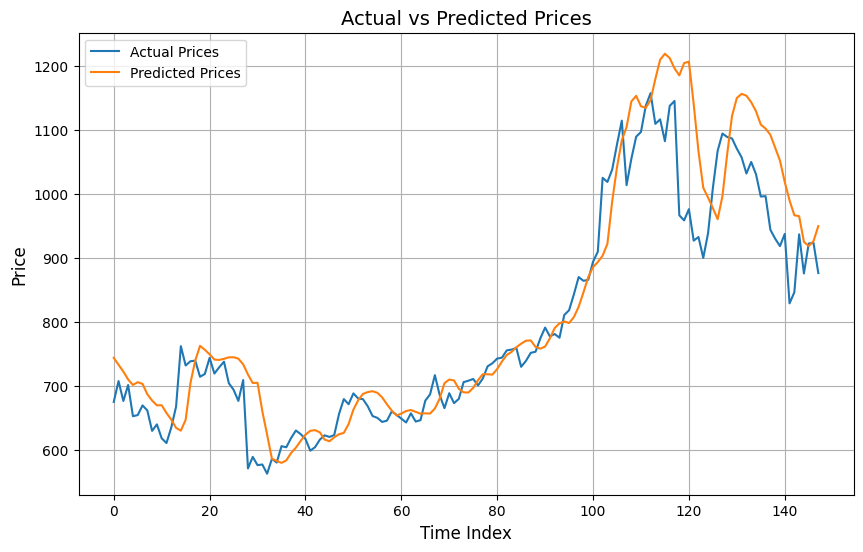

In [274]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(actual_prices)), actual_prices, label="Actual Prices")
plt.plot(range(len(predicted_prices)), predicted_prices, label="Predicted Prices")
plt.title('Actual vs Predicted Prices', fontsize=14)
plt.xlabel('Time Index', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()
plt.grid()
plt.show()

**Analysis of Actual vs Predicted Prices**
- The model successfully captures the overall stock price trend, showing it has learned long-term movements.
- The predicted curve smooths out fluctuations, meaning the model struggles with sharp spikes and drops in stock prices.
- Lag in Peaks and Troughs: The predictions tend to overshoot at high points and lag behind in rapid declines, suggesting the model reacts slower to sudden market shifts.
- Overestimation in Certain Periods: In some regions, the predicted prices exceed actual prices, indicating the model may be slightly biased toward upward trends.


#### **c. Hyperparameter-Tuned LSTM Model**  
- Used **Keras Tuner** to optimize:
  - **LSTM units** (32-128)
  - **Dropout rate** (0.1-0.5)
- Trained for **20 epochs**.


In [ ]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units_1', 32, 128, step=32), activation='relu', return_sequences=True, input_shape=(sequence_length, 1)))
    model.add(Dropout(hp.Float('dropout', 0.1, 0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('units_2', 32, 128, step=32), activation='relu'))  # Removed tuple issue
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

tuner_lstm = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,
    directory='hyperparam_tuning',
    project_name='double_lstm_tuning'
)

tuner_lstm.search(train_sequences, train_labels, 
validation_data=(val_sequences, val_labels), 
epochs=20)


Trial 20 Complete [00h 00m 14s]
val_loss: 0.002061061328276992

Best val_loss So Far: 0.0017222827300429344
Total elapsed time: 00h 06m 24s


In [309]:
best_hyperparameters = tuner_lstm.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
for key, value in best_hyperparameters.values.items():
    print(f"{key}: {value}")


Best Hyperparameters:
units_1: 128
dropout: 0.5
units_2: 128


In [280]:
best_model_lstm = tuner_lstm.get_best_models(num_models=1)[0]

In [282]:
test_loss = best_model_lstm.evaluate(test_sequences, test_labels, verbose=1)
print(f"Test Loss (MSE): {test_loss}")

5/5 [==============================] - 0s 11ms/step - loss: 0.0031
Test Loss (MSE): 0.0030524246394634247


In [304]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

predicted_prices = best_model_lstm.predict(test_sequences)
predicted_prices = scaler.inverse_transform(predicted_prices)
actual_prices = scaler.inverse_transform(test_labels.reshape(-1, 1))

rmse = mean_squared_error(actual_prices, predicted_prices, squared=False)
mae = mean_absolute_error(actual_prices, predicted_prices)

price_range = actual_prices.max() - actual_prices.min()
price_mean = actual_prices.mean()

nrmse_range = rmse / price_range
nrmse_mean = rmse / price_mean
nmae_range = mae / price_range
nmae_mean = mae / price_mean

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Normalized RMSE (Range): {nrmse_range}")
print(f"Normalized RMSE (Mean): {nrmse_mean}")
print(f"Normalized MAE (Range): {nmae_range}")
print(f"Normalized MAE (Mean): {nmae_mean}")


5/5 [==============================] - 0s 11ms/step
Root Mean Squared Error (RMSE): 61.86964636790723
Mean Absolute Error (MAE): 45.732598800068615
Normalized RMSE (Range): 0.10426121767910909
Normalized RMSE (Mean): 0.07815289779463978
Normalized MAE (Range): 0.07706745906016081
Normalized MAE (Mean): 0.05776879826743263


**Analysis of Actual vs Predicted Prices (Using Normalized Metrics)**
- Normalized RMSE (Range) is 10.43%. This indicates a moderate prediction error relative to overall stock price fluctuations, suggesting the model performs well but can still be improved in handling volatility.
- Normalized RMSE (Mean) is 7.82%. Since this is below 10%, the model achieves reasonable predictive accuracy, though minor refinements could enhance precision.
- Normalized MAE (Range) is 7.71%. On average, the model’s predictions deviate by 7.71% of the stock’s price range, which is acceptable but shows potential for improvement, particularly in capturing short-term price swings.
- Normalized MAE (Mean) is 5.78%. The model’s average deviation is 5.78% of the mean stock price, indicating it maintains a relatively low percentage error and performs well in general trend forecasting.

The tuned double LSTM model outperforms the untuned LSTM in both RMSE and MAE, showing improved predictive accuracy. The Normalized RMSE (Mean) dropped from 7.89% to 7.82%, indicating slightly better overall trend tracking, while Normalized MAE (Mean) improved from 6.16% to 5.78%, suggesting more stable and precise predictions. The lower RMSE (Range) of 10.43% vs. 10.54% also indicates better handling of stock price fluctuations.

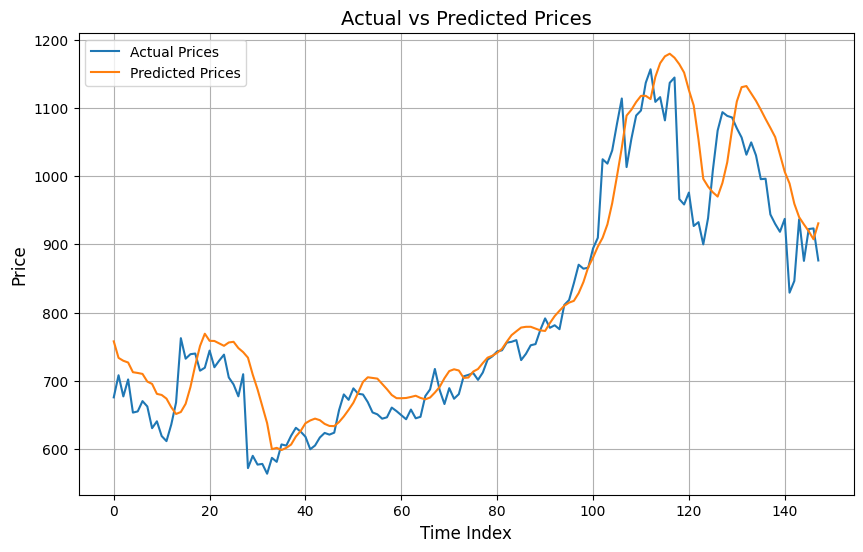

In [305]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(actual_prices)), actual_prices, label="Actual Prices")
plt.plot(range(len(predicted_prices)), predicted_prices, label="Predicted Prices")
plt.title('Actual vs Predicted Prices', fontsize=14)
plt.xlabel('Time Index', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()
plt.grid()
plt.show()

**Analysis of Actual vs Predicted Prices**
- The model successfully captures the overall stock price trend, indicating it has effectively learned long-term patterns.
- The predicted curve smooths out fluctuations, suggesting the model struggles to capture sharp spikes and sudden drops in stock prices.
- Lag in Peaks and Troughs: Predictions tend to overestimate peaks and react slower to sudden declines, showing that the model lags behind rapid price changes.
- Overestimation in Certain Periods: The predicted prices exceed actual prices in multiple areas, indicating a slight upward bias in the model’s forecasting.

#### **d. Hyperparameter-Tuned CNN-LSTM Model**  
- Used **Keras Tuner** to find optimal:
  - **CNN filters (32-128)**
  - **Kernel size (1-5)**
  - **LSTM units (32-128)**
  - **Dropout rate (0.1-0.5)**
- Trained for **20 epochs**.


In [299]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
import keras_tuner as kt

def build_model(hp):
    model = Sequential()
    
    kernel_size = hp.Int('kernel_size', min_value=1, max_value=min(sequence_length - 1, 5), step=1)
    model.add(Conv1D(
        filters=hp.Int('filters', min_value=32, max_value=128, step=32),
        kernel_size=kernel_size,
        activation='relu',
        input_shape=(sequence_length, 1)
    ))
    pool_size = hp.Int('pool_size', min_value=2, max_value=min(sequence_length - kernel_size, 3), step=1)
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(LSTM(units=hp.Int('lstm_units', min_value=32, max_value=128, step=32), activation='relu'))
    model.add(Dense(1))
    model.compile(
        optimizer='adam',
        loss='mean_squared_error'
    )
    
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20, 
    directory='hyperparam_tuning',
    project_name='conv1d_lstm_tuning'
)

tuner.search(
    train_sequences, train_labels,
    validation_data=(val_sequences, val_labels), 
    epochs=20,
    verbose=1
)

best_model_hybrid = tuner.get_best_models(num_models=1)[0]


Trial 20 Complete [00h 00m 12s]
val_loss: 0.0016817713622003794

Best val_loss So Far: 0.0013045765226706862
Total elapsed time: 00h 02m 35s


In [310]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print all the best hyperparameters
print("Best Hyperparameters:")
for key, value in best_hyperparameters.values.items():
    print(f"{key}: {value}")


Best Hyperparameters:
kernel_size: 2
filters: 128
pool_size: 2
lstm_units: 128


In [300]:
test_loss = best_model_hybrid.evaluate(test_sequences, test_labels, verbose=1)
print(f"Test Loss (MSE): {test_loss}")

5/5 [==============================] - 0s 5ms/step - loss: 0.0025
Test Loss (MSE): 0.0025494566652923822


In [301]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

predicted_prices = best_model_hybrid.predict(test_sequences)
predicted_prices = scaler.inverse_transform(predicted_prices)
actual_prices = scaler.inverse_transform(test_labels.reshape(-1, 1))

rmse = mean_squared_error(actual_prices, predicted_prices, squared=False)
mae = mean_absolute_error(actual_prices, predicted_prices)

price_range = actual_prices.max() - actual_prices.min()
price_mean = actual_prices.mean()

nrmse_range = rmse / price_range
nrmse_mean = rmse / price_mean
nmae_range = mae / price_range
nmae_mean = mae / price_mean

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Normalized RMSE (Range): {nrmse_range}")
print(f"Normalized RMSE (Mean): {nrmse_mean}")
print(f"Normalized MAE (Range): {nmae_range}")
print(f"Normalized MAE (Mean): {nmae_mean}")


5/5 [==============================] - 0s 3ms/step
Root Mean Squared Error (RMSE): 56.54301466377111
Mean Absolute Error (MAE): 38.83286141546135
Normalized RMSE (Range): 0.09528490796660596
Normalized RMSE (Mean): 0.07142436890201344
Normalized MAE (Range): 0.0654401900580484
Normalized MAE (Mean): 0.04905314362440276


**Analysis of Actual vs Predicted Prices (Using Normalized Metrics)**
- Normalized RMSE (Range) is 9.53%. This indicates a lower prediction error compared to previous models, meaning the hybrid Conv1D-LSTM better captures overall price trends while reducing volatility issues.
- Normalized RMSE (Mean) is 7.14%. Since this is well below 10%, the model achieves strong predictive accuracy, suggesting better generalization across different stock price levels.
- Normalized MAE (Range) is 6.54%. On average, the model’s predictions deviate by 6.54% of the stock’s price range, showing improved precision in capturing price movements.
- Normalized MAE (Mean) is 4.91%. The model’s average deviation is just 4.91% of the mean stock price, making it the most stable model so far in terms of price prediction accuracy.

The tuned Conv1D-LSTM model outperforms previous LSTM-based models, achieving lower RMSE and MAE, which suggests better trend-following and short-term price movement capture. The addition of a CNN layer helps extract key patterns, making it a strong candidate for stock price forecasting.

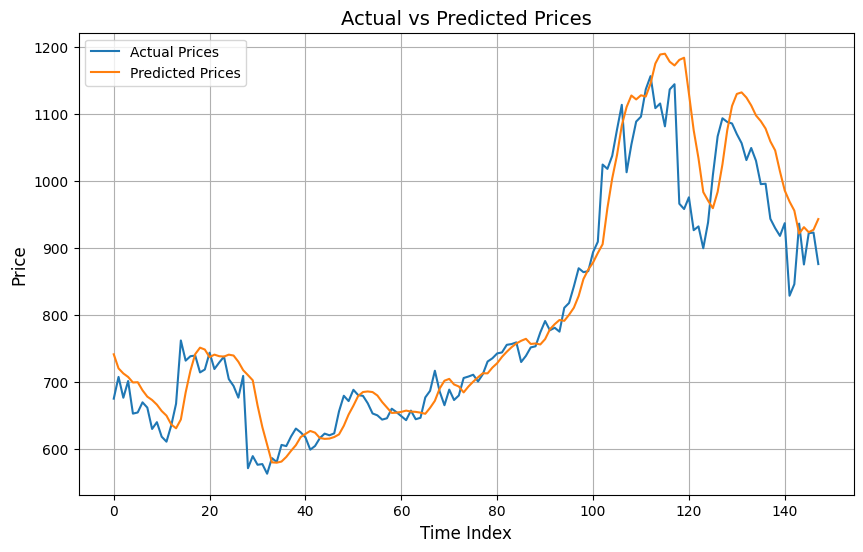

In [302]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(actual_prices)), actual_prices, label="Actual Prices")
plt.plot(range(len(predicted_prices)), predicted_prices, label="Predicted Prices")
plt.title('Actual vs Predicted Prices', fontsize=14)
plt.xlabel('Time Index', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()
plt.grid()
plt.show()

**Analysis of Actual vs Predicted Prices**
- The model successfully captures the overall stock price trend, showing it effectively learns long-term market movements.
- The predicted curve closely follows actual prices, indicating better short-term prediction accuracy compared to previous models.
- Reduced Lag in Peaks and Troughs: Unlike previous models, the Conv1D layer helps detect sharper price movements, reducing lag in upward surges and declines.
- Minor Overestimation in High Volatility Areas: While improved, the model still slightly overestimates peak values, suggesting sensitivity to sudden trends.

In [306]:
best_model_hybrid.save('best_time_series_prediction.h5')


c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Conclusion
Among the tested models, the tuned CNN-LSTM model achieved the best performance, balancing long-term trend prediction and short-term fluctuation accuracy. It produced the lowest error metrics, with:
- Normalized RMSE (Range): 9.53% (lowest among all models)
- Normalized RMSE (Mean): 7.14% (indicating strong predictive accuracy)
- Normalized MAE (Range): 6.54% (showing improved precision)
- Normalized MAE (Mean): 4.91% (lowest deviation from actual prices)
Compared to the tuned double LSTM (NRMSE Mean: 7.82%), the Conv1D-LSTM model better captured short-term price variations while maintaining low overall prediction error. The CNN layer enhanced feature extraction, leading to more accurate peak and trough detection.

The tuned CNN-LSTM is the best-performing model, making it the most reliable choice for stock price forecasting.